<a href="https://colab.research.google.com/github/nicolas1805961/Deep-learning/blob/main/tp1_dlim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLIM TP1 Nicolas Portal

On extrait les données des archives dans le dossier 'train' pour les données d'entrainement et le dossier 'test' pour les données de test.

In [25]:
import zipfile
import os

with zipfile.ZipFile('/content/drive/My Drive/iSeg-2017-Training.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/train/')

with zipfile.ZipFile('/content/drive/My Drive/iSeg-2017-Testing.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/test/')

On charge les fichiers sans des listes. On supprime la dernière dimension. On sépare les données labels, T1 et T2 dans des listes différentes.

In [26]:
import zipfile
import os

def get_file_list(folder):

  T1_paths = sorted([os.path.join(os.getcwd(), folder, x) for x in os.listdir(folder) if 'T1' in x and 'img' in x], key=lambda x: int(x.split('-')[1]))
  T2_paths = sorted([os.path.join(os.getcwd(), folder, x) for x in os.listdir(folder) if 'T2' in x and 'img' in x], key=lambda x: int(x.split('-')[1]))
  label_paths = sorted([os.path.join(os.getcwd(), folder, x) for x in os.listdir(folder) if 'label' in x and 'img' in x], key=lambda x: int(x.split('-')[1]))

  T1_files_list = [np.squeeze(nib.load(filepath).get_fdata(), -1) for filepath in T1_paths]
  T2_files_list = [np.squeeze(nib.load(filepath).get_fdata(), -1) for filepath in T2_paths]
  label_files_list = [np.squeeze(nib.load(filepath).get_fdata(), -1) for filepath in label_paths]

  return T1_files_list, T2_files_list, label_files_list

On va dans un premier temps concatener nos slices sur le dernier axe puis passer cet axe en première position. De cette manière il sera plus simple de donner les slices en 2d au réseau par batch. Ne disposant que de 10 sujets, on a choisi de partir sur de la segmentation 2d par slice plutôt que de la segmentation 3d car cette dernière méthode aurait nécéssité plus de données.

Dans la cellule ci-dessous, on a enlevé les slices vides grace à la fonction np.any() et l'utilisation d'un masque. Si on avait gardé les slices vides, on aurait eu trop de slices avec des pixels noirs ce qui aurait pu biaiser l'entrainement (trop de valeurs à 0 par rapport aux autres valeurs).

 On normalise également les données en divisant la valeur des pixels de chaque slice par la valeur maximal du dataset pour T1 et T2. De cette manière on a des valeurs entre 0 et 1 ce qui est preferable pour l'entrainement. Cela permet d'avoir des valeurs à la même échelle. Plutôt que de normaliser les données entre 0 et 1, on aurait pu les standardiser en soustrayant la moyenne et divisant par l'écart type. Ici, on a préféré diviser par la valeur maximum du dataset plutôt que la valeur maximum par image car comme les slices sont acquises avec la même méthode (T1 ou T2) et sans alterations des condition d'acquisition, la différence entre chaque slices apporte de l'information.

  On va également empiler T1 et T2 avec la fonction stack() de numpy de manière à avoir des images avec deux cannaux. De cette manière, le réseau disposera davantage d'informations. En effet, ces informations étant complémentaires, cela devrait renforcer la convergence du réseau.

 Enfin, on fait le 'one hot encoding' sur les labels mais en l'adaptant à la fonction de cout qui sera ici la 'sparse categorical crossentropy' et qui ne necessite pas de vecteur pour chaque classe mais simplement une valeur différente. On ramène ces valeurs entre 0 et 3 de manière à pouvoir une couche de sortie du réseau à 4 neuronnes pour les 4 classes (en gardant des pixels à 250, il aurait fallu 250 neuronnes de sortie).



In [27]:
def process_data_train(T1_files_list, T2_files_list, label_files_list):

  T1_train = np.swapaxes(np.concatenate(T1_files_list, axis=-1), 0, 2)
  T2_train = np.swapaxes(np.concatenate(T2_files_list, axis=-1), 0, 2)
  Y_train = np.swapaxes(np.concatenate(label_files_list, axis=-1), 0, 2)

  T1_train = np.swapaxes(T1_train, 1, 2)
  T2_train = np.swapaxes(T2_train, 1, 2)
  Y_train = np.swapaxes(Y_train, 1, 2)

  mask = np.any(Y_train, axis=(1, 2))
  Y_train = Y_train[mask].astype(np.uint16)
  T1_train = T1_train[mask]
  T2_train = T2_train[mask]

  T1_train /= np.amax(T1_train, axis=(1, 2)).reshape(-1, 1, 1)
  T2_train /= np.amax(T2_train, axis=(1, 2)).reshape(-1, 1, 1)
  X_train = np.stack([T1_train, T2_train], axis=-1)

  Y_train = np.select([Y_train == 0, Y_train == 10, Y_train == 150, Y_train == 250], [0, 1, 2, 3])

  return X_train, Y_train

On traite ici le dataset de test de la même manière que le dataset de train, les données de validation en moins.

In [28]:
def process_data_test(T1_files_list, T2_files_list):

  T1_train = np.swapaxes(np.concatenate(T1_files_list, axis=-1), 0, 2)
  T2_train = np.swapaxes(np.concatenate(T2_files_list, axis=-1), 0, 2)

  T1_train = np.swapaxes(T1_train, 1, 2)
  T2_train = np.swapaxes(T2_train, 1, 2)

  T1_max = np.amax(T1_train, axis=(1, 2)).reshape(-1, 1, 1)
  T2_max = np.amax(T2_train, axis=(1, 2)).reshape(-1, 1, 1)

  T1_mask = np.any(T1_train, axis=(1, 2))
  T2_mask = np.any(T2_train, axis=(1, 2))

  T1_train[T1_mask] /= T1_max[T1_mask]
  T2_train[T2_mask] /= T2_max[T2_mask]
  X_train = np.stack([T1_train, T2_train], axis=-1)

  return X_train

Ci-dessous on effectue la séparation entre données d'entrainement et données de validation. On choisit deux patients au hasard parmis la liste de patients (2/10 eme des patients) pour représenter nos données de validation. On sépare donc par patient et non pas par slice de manière à avoir dans les données de validation tous types de slices, y compris des slices avec beaucoup de pixels noirs.

In [29]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_val_data(T1_files_list, T2_files_list, label_files_list):

  val_index = np.random.randint(0, 10, 2)
  print(val_index)
  print(len(T1_files_list))
  T1_val_files = [T1_files_list.pop(i) for i in val_index]
  T2_val_files = [T2_files_list.pop(i) for i in val_index]
  Y_val_files = [label_files_list.pop(i) for i in val_index]

  X_train, Y_train = process_data_train(T1_files_list, T2_files_list, label_files_list)
  X_val, Y_val = process_data_train(T1_val_files, T2_val_files, Y_val_files)

  return X_train, Y_train, X_val, Y_val

La fonction ci-dessous permet de faire de la data augmentation. On double le nombre d'images. Pour cela on fait simplement un flip de chaque image dans le sens haut/bas.

In [30]:
def augment_data(T1_files_list, T2_files_list, label_files_list):
  for i in range(len(T1_files_list)):
    T1_files_list[i] = np.concatenate([np.flipud(T1_files_list[i]), T1_files_list[i]], axis=-1)
    T2_files_list[i] = np.concatenate([np.flipud(T2_files_list[i]), T2_files_list[i]], axis=-1)
    label_files_list[i] = np.concatenate([np.flipud(label_files_list[i]), label_files_list[i]], axis=-1)
  return T1_files_list, T2_files_list, label_files_list

Ci-dessous on traite les données d'entrainement.

(144, 192, 512)
[0 1]
10


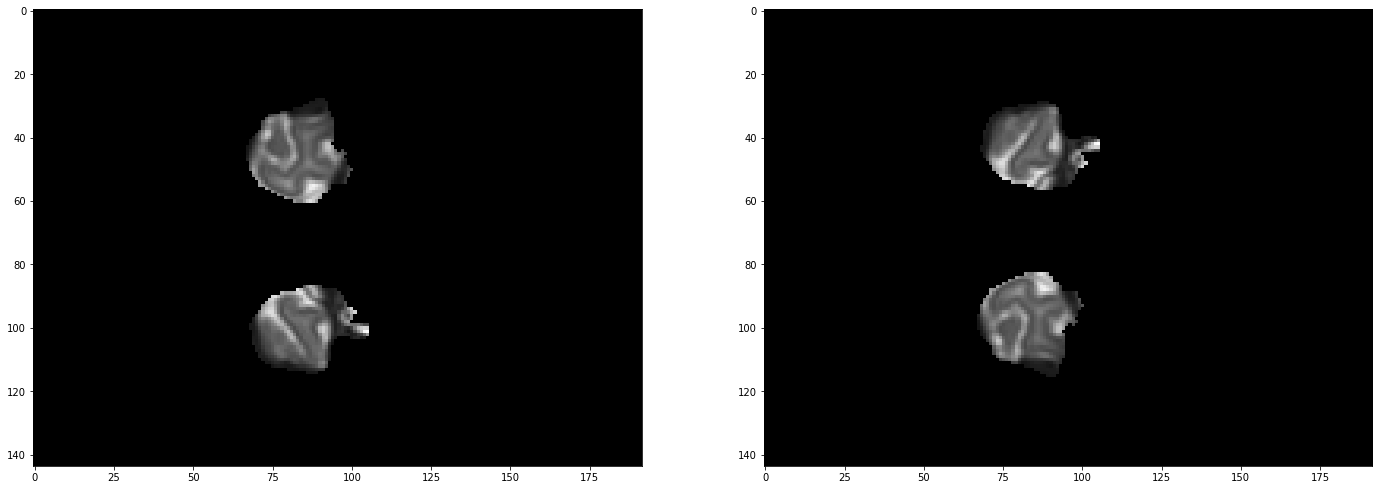

In [31]:
import cv2 as cv

T1_files_list, T2_files_list, label_files_list = get_file_list('train')
T1_files_list, T2_files_list, label_files_list = augment_data(T1_files_list, T2_files_list, label_files_list)
print(T1_files_list[0].shape)

fig, ax = plt.subplots(1, 2, figsize=(24, 10))
ax[0].imshow(T2_files_list[4][..., 100], cmap='gray')
ax[1].imshow(T2_files_list[4][..., 356], cmap='gray')

X_train, Y_train, X_val, Y_val = create_val_data(T1_files_list, T2_files_list, label_files_list)

On verifie qu'on a les bonnes 'shapes' ainsi que des données normalisées.

In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(np.unique(X_train))
print(np.unique(Y_train))
print(np.unique(X_val))
print(np.unique(Y_val))

(1598, 144, 192, 2)
(1598, 144, 192)
(422, 144, 192, 2)
(422, 144, 192)
[0.         0.00111483 0.00247219 ... 0.9989605  0.99896158 1.        ]
[0 1 2 3]
[0.         0.00531915 0.00532623 ... 0.99893955 0.99894626 1.        ]
[0 1 2 3]


On affiche les slices T1 et T2 ainsi que la verité terrain pour vérifier qu'il n'y a rien d'anormal.

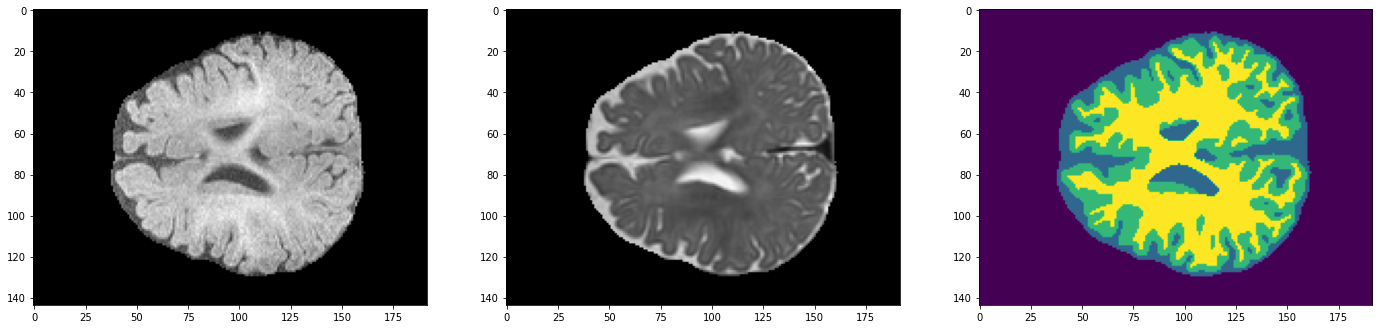

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(24, 10))
ax[0].imshow(X_train[256, ..., 0], cmap='gray')
ax[1].imshow(X_train[256, ..., 1], cmap='gray')
ax[2].imshow(Y_train[256])

On definie ci-dessous un generateur de données qui va être utilisé par le reseau pour accéder aux slices grâce à la méthode '__getitem__' qui retournera un batch de slices ainsi qu'un batch de labels. On a à peu près 800 données d'entrainement. On fixe le batch size à 16. On veille aussi à mélanger les données au debut de l'entrainement et entre chaque epoch de manière à éviter que le modèle se base sur l'ordre dans lequel les données lui sont données pour apprendre. Cela pourrait conduire à du surapprentisage. On veut donc éviter que l'ordre des données ait une conséquence sur ce que le modèle apprend.

In [34]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle


class Data_generator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, X, Y):
        self.batch_size = batch_size
        self.X = X
        self.Y = Y
        self.indices = np.arange(X.shape[0])

    def on_train_begin(self):
      np.random.shuffle(self.indices)

    def on_epoch_end(self):
      np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.Y) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.X[inds]
        batch_y = self.Y[inds]
        return batch_x, batch_y

# Instantiate data Sequences for each split
batch_size = 16
train_gen = Data_generator(batch_size, X_train, Y_train)
val_gen = Data_generator(batch_size, X_val, Y_val)

La fonction ci-dessous permet au réseau de faire passer un batch dans deux couches de convolutions. On utilise la batch normalisation pour améliorer l'entrainement. Cela permet de s'assurer que les valeurs d'entrée des couche ont une distribution similaire. On accroit donc la stabilité du model ce qui permet également de réduire l'overfiting. En outre, il a été montré que la batch normalisation permet au modèle d'être plus robuste à différentes valeurs de learning rates. On utilise relu comme fonction d'activation car c'est souvent la plus efficace.

In [35]:
def conv_bloc(filters, inputs):
  x = layers.Conv2D(filters, 3, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(filters, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  return x

Ci-dessous on crée un réseau U net. Il a été montré que ces réseaux sont très efficace pour la segmentation d'images. On a ici suivi le modèle suivant:

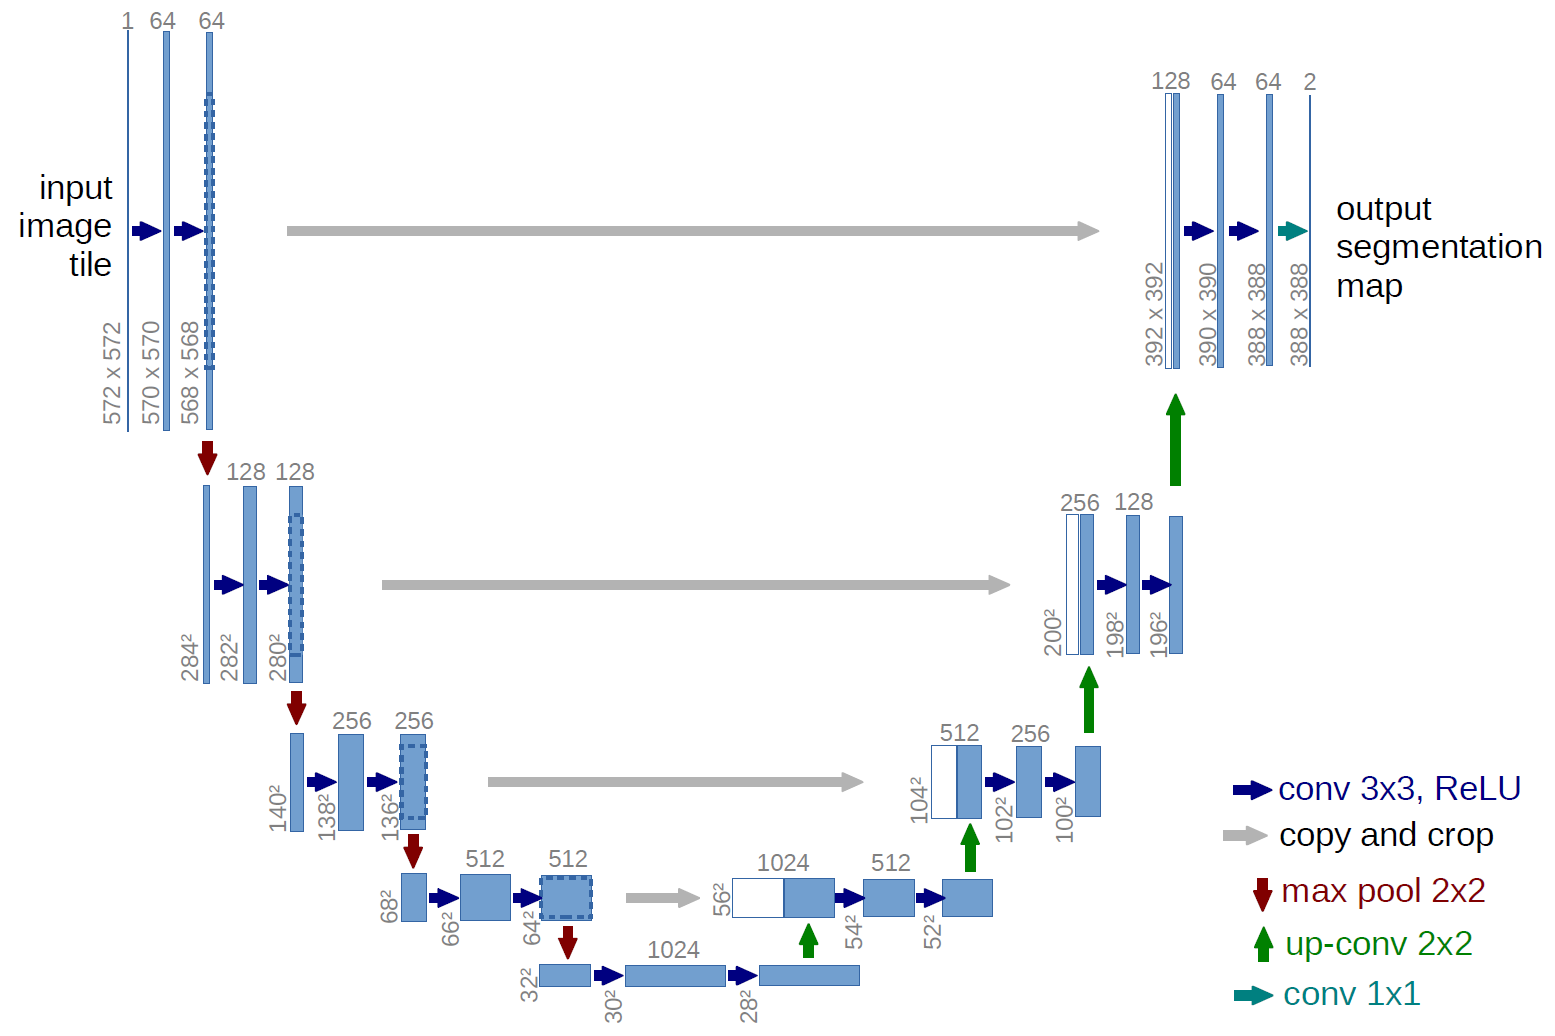

Les couches de convolution 2d vont augmenter du nombre de filtres spécifiés en argument le nombre d'elements dans la dernière dimension du batch. La couche de max pooling va avec une stride de 2 va ici réduire la taille de l'image par quatre (diviser par deux la hauteur et largeur).

Dans la partie gauche du 'U', on répète deux couches de convolution suivi d'une couche de max pooling. En bas du 'U' on se retrouve avec des images de petites taille mais beaucoup de features en dernière dimension. En bas du 'U' on a deux couches de convolution mais sans max pooling cette fois (on ne veut pas descendre plus).

La couche conv2dtranspose va permettre de remonter dans la partie droite du 'U' en réduisant par deux le nombre de features à chaque utilisation. On combine cela avec une couche d'upscaling de manière à faire grandir la taille de nos images ( l'upscaling avec pour paramètre 2 multiplie la taille de nos images par 4, *2 en hauteur et largeur).

En combinant l'upscaling et la conv2dtranspose on remonte progressivement dans le 'U'. On effectue cette combinaison autant de fois qu'on a effectué la combinaison conv2d maxpooling dans la partie gauche du 'U'. Cela va permettre de retrouver une image de la même taille qu'en entrée. Cela est necessaire pour faire de la ségmentation. A chaque étage de la partie droite du 'U' on va concatener la couche de l'étage de gauche correspondant. On a stocké ces couches dans une liste avant chaque max pooling dans la partie gauche.

Enfin, on applique une couche de convolution ayant pour nombre de filtres le nombre de classes, ici quatre. On utilise la fonction softmax comme dernière fonction d'activation car cette dernière est adaptée aux problèmes de classifications car non linéaire. Elle renvoit en sortie la probabilité d'appartenance du pixel à chaque classe (car on a 4 neuronnes). On utilise softmax plutôt que sigmoid car on est en présence d'un problème de classification multi-classes.

In [36]:
from tensorflow.keras.layers import concatenate

def get_model():
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((144, 192, 2))

    layer_list = []
    filters_left = [128, 256, 512]
    filters_right = [512, 256, 128, 64]

    x = conv_bloc(filters_right[-1], inputs)
    layer_list.append(tf.identity(x))
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    for filters in filters_left:
        x = conv_bloc(filters, x)
        layer_list.append(tf.identity(x))
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    print(x.shape)
    x = conv_bloc(filters_left[-1] * 2, x)

    for j in range(0, len(filters_left) + 1):
      print(layer_list[j].shape)

    for i, filters in zip(range(len(filters_left), -1, -1), filters_right):
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.UpSampling2D(2)(x)
        x = concatenate([x, layer_list[i]])
        x = conv_bloc(filters, x)

    outputs = layers.Conv2D(4, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model


keras.backend.clear_session()

model = get_model()
model.summary()

(None, 9, 12, 512)
(None, 144, 192, 64)
(None, 72, 96, 128)
(None, 36, 48, 256)
(None, 18, 24, 512)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 144, 192, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 144, 192, 64) 1216        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 144, 192, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 144, 192, 64) 0           batch_normalization[0

Ci-dessous on utilise Adam avec un learning rate diminué (on obtient de meilleurs résultats avec une dimminution du learning rate) en tant qu'optimizer. Comme évoqué plus haut, on utilise la categorical crossentropy comme fonction de cout car on a ici on problème similaire à de la classification avec plusieurs classes possibles, ici quatre. On utilise sa variante 'sparse' de manière à ne pas avoir à faire le 'one hot encoding'. Ainsi on garde une image en input ayant une seule valeur par pixel alors qu'on aurait eu besoin de quatre valeurs par pixel avec simplement la 'categorical crossentropy'.

In [37]:
from keras import optimizers

adam = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=adam, metrics=['accuracy'], loss="sparse_categorical_crossentropy")

# Train the model, doing validation at the end of each epoch.
model.fit(train_gen, epochs=30, validation_data=val_gen)

Epoch 1/30
99/99 [==============================] - 40s 408ms/step - loss: 0.2819 - accuracy: 0.9015 - val_loss: 0.8989 - val_accuracy: 0.6993
Epoch 2/30
99/99 [==============================] - 42s 421ms/step - loss: 0.1268 - accuracy: 0.9498 - val_loss: 0.9832 - val_accuracy: 0.7041
Epoch 3/30
99/99 [==============================] - 43s 439ms/step - loss: 0.1030 - accuracy: 0.9580 - val_loss: 0.4909 - val_accuracy: 0.7731
Epoch 4/30
99/99 [==============================] - 43s 432ms/step - loss: 0.0925 - accuracy: 0.9617 - val_loss: 0.3247 - val_accuracy: 0.8753
Epoch 5/30
99/99 [==============================] - 43s 437ms/step - loss: 0.0861 - accuracy: 0.9640 - val_loss: 0.2277 - val_accuracy: 0.9051
Epoch 6/30
99/99 [==============================] - 43s 435ms/step - loss: 0.0814 - accuracy: 0.9658 - val_loss: 0.1388 - val_accuracy: 0.9406
Epoch 7/30
99/99 [==============================] - 43s 436ms/step - loss: 0.0762 - accuracy: 0.9679 - val_loss: 0.1118 - val_accuracy: 0.9535

On remarque que la 'val_accuracy' est assez proche de l'accuracy ce qui signifie qu'on a peu d'overfitting. On aurait pu utiliser du dropout en cas de surapprentissage plus prononcé.

On sauvegarde le modèle.

In [38]:
model.save("/content/drive/MyDrive/model_dlim")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_dlim/assets


On charge le modèle.

In [39]:
model = keras.models.load_model('/content/drive/MyDrive/model_dlim')

On traite les données de test de la même manière que les données d'entrainement.

In [40]:
T1_files_list, T2_files_list, _ = get_file_list('test')
T1_files_list[-1] = T1_files_list[-1][(160-144)//2:-(160-144)//2, ...]
T2_files_list[-1] = T2_files_list[-1][(160-144)//2:-(160-144)//2, ...]
X_test = process_data_test(T1_files_list, T2_files_list)
print(X_test.shape)

(3328, 144, 192, 2)


Ci-dessous, on récupère dans un premier temps l'indice de probabilité maximale dans nos prédictions pour les 4 neuronnes de sortie. Puis on re-convertit nos classes suivant leur valeur initiale dans les fichiers labels. Enfin, on réordonne les axes conformément aux données qu'on avait au début avant de les traiter. On affiche des résultats pour vérifier la cohérence.

(13, 144, 192, 256)
(13, 144, 192, 256, 2)
uint8


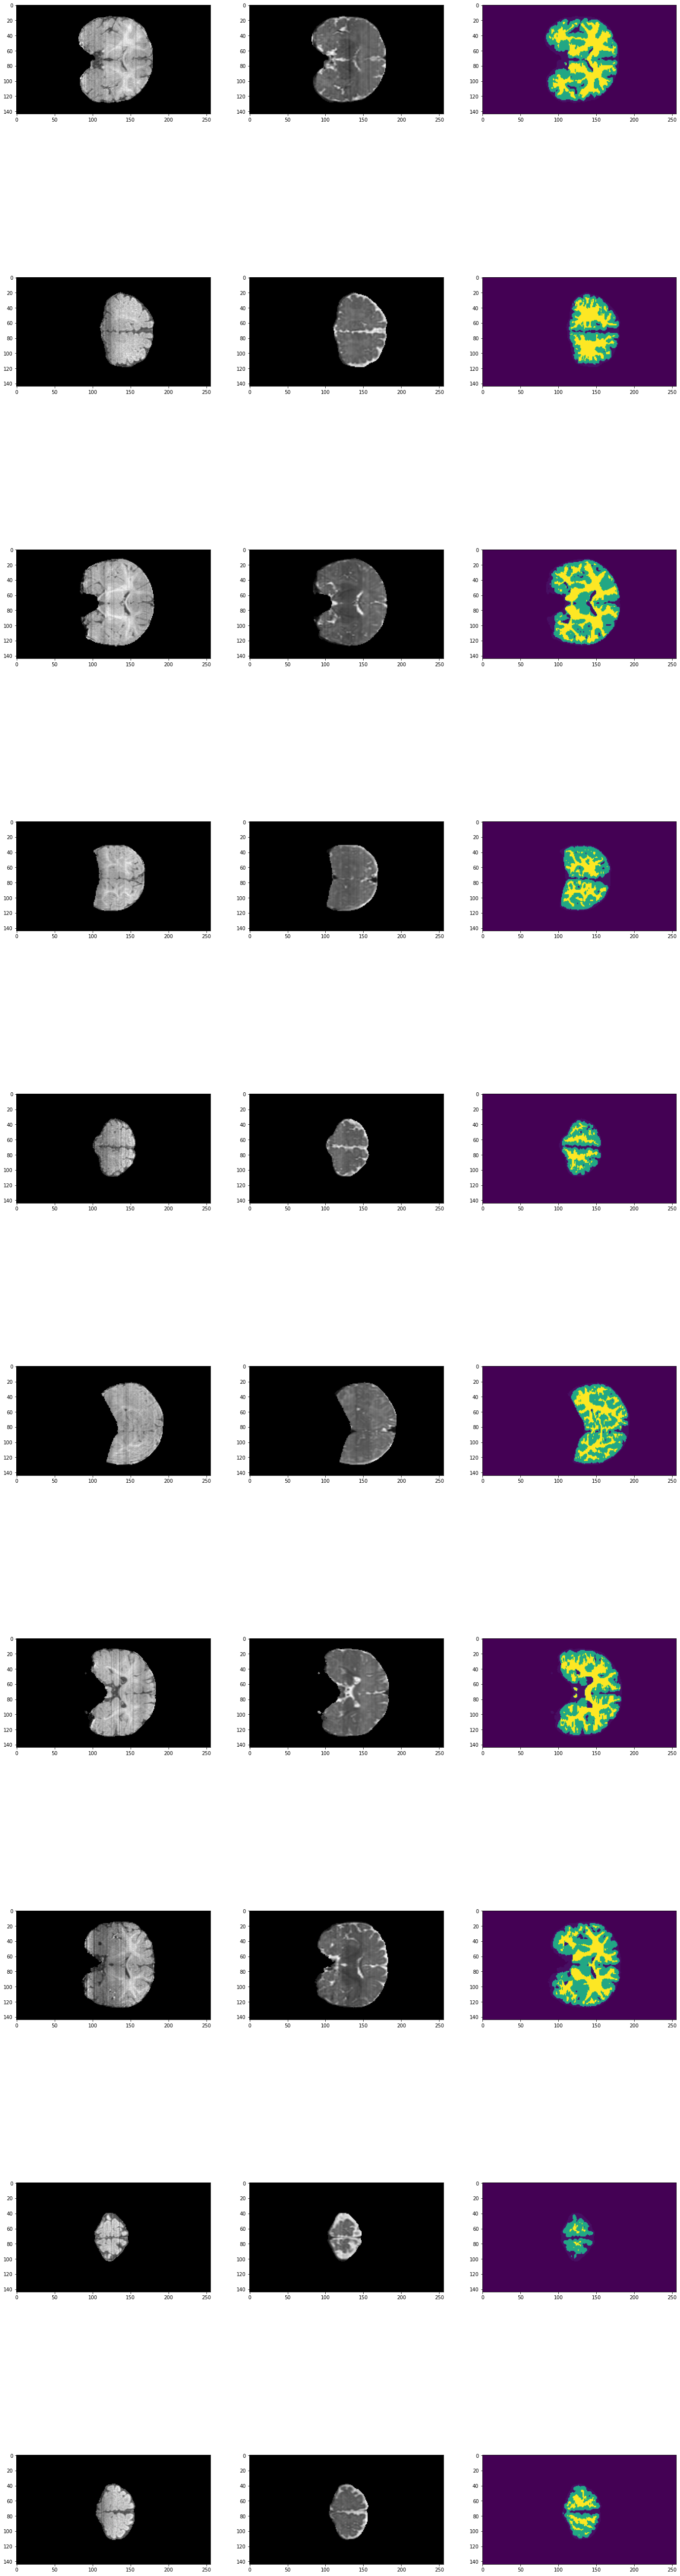

In [41]:
val_preds = np.argmax(model.predict(X_test), -1)
val_preds = np.select([val_preds == 0, val_preds == 1, val_preds == 2, val_preds == 3], [0, 10, 150, 250])

val_preds_2 = val_preds.reshape(13, 256, 144, 192, order='C')
X_test_2 = X_test.reshape(13, 256, 144, 192, 2, order='C')

val_preds_2 = np.moveaxis(val_preds_2, 1, -1).astype(np.uint8)
X_test_2 = np.moveaxis(X_test_2, 1, -2)

print(val_preds_2.shape)
print(X_test_2.shape)
print(val_preds_2.dtype)

fig, ax = plt.subplots(10, 3, figsize=(24, 100))

subject_indices = np.random.randint(0, 13, 10)
image_indices = np.random.randint(0, 192, 10)
for plot_index, (image_index, subject_index) in enumerate(zip(image_indices, subject_indices)):
  ax[plot_index, 0].imshow(X_test_2[subject_index, :, image_index, :, 0], cmap='gray')
  ax[plot_index, 1].imshow(X_test_2[subject_index, :, image_index, :, 1], cmap='gray')
  ax[plot_index, 2].imshow(val_preds_2[subject_index, ..., image_index, :])

On sauvegarde les données.

(13, 144, 192, 256)
uint8


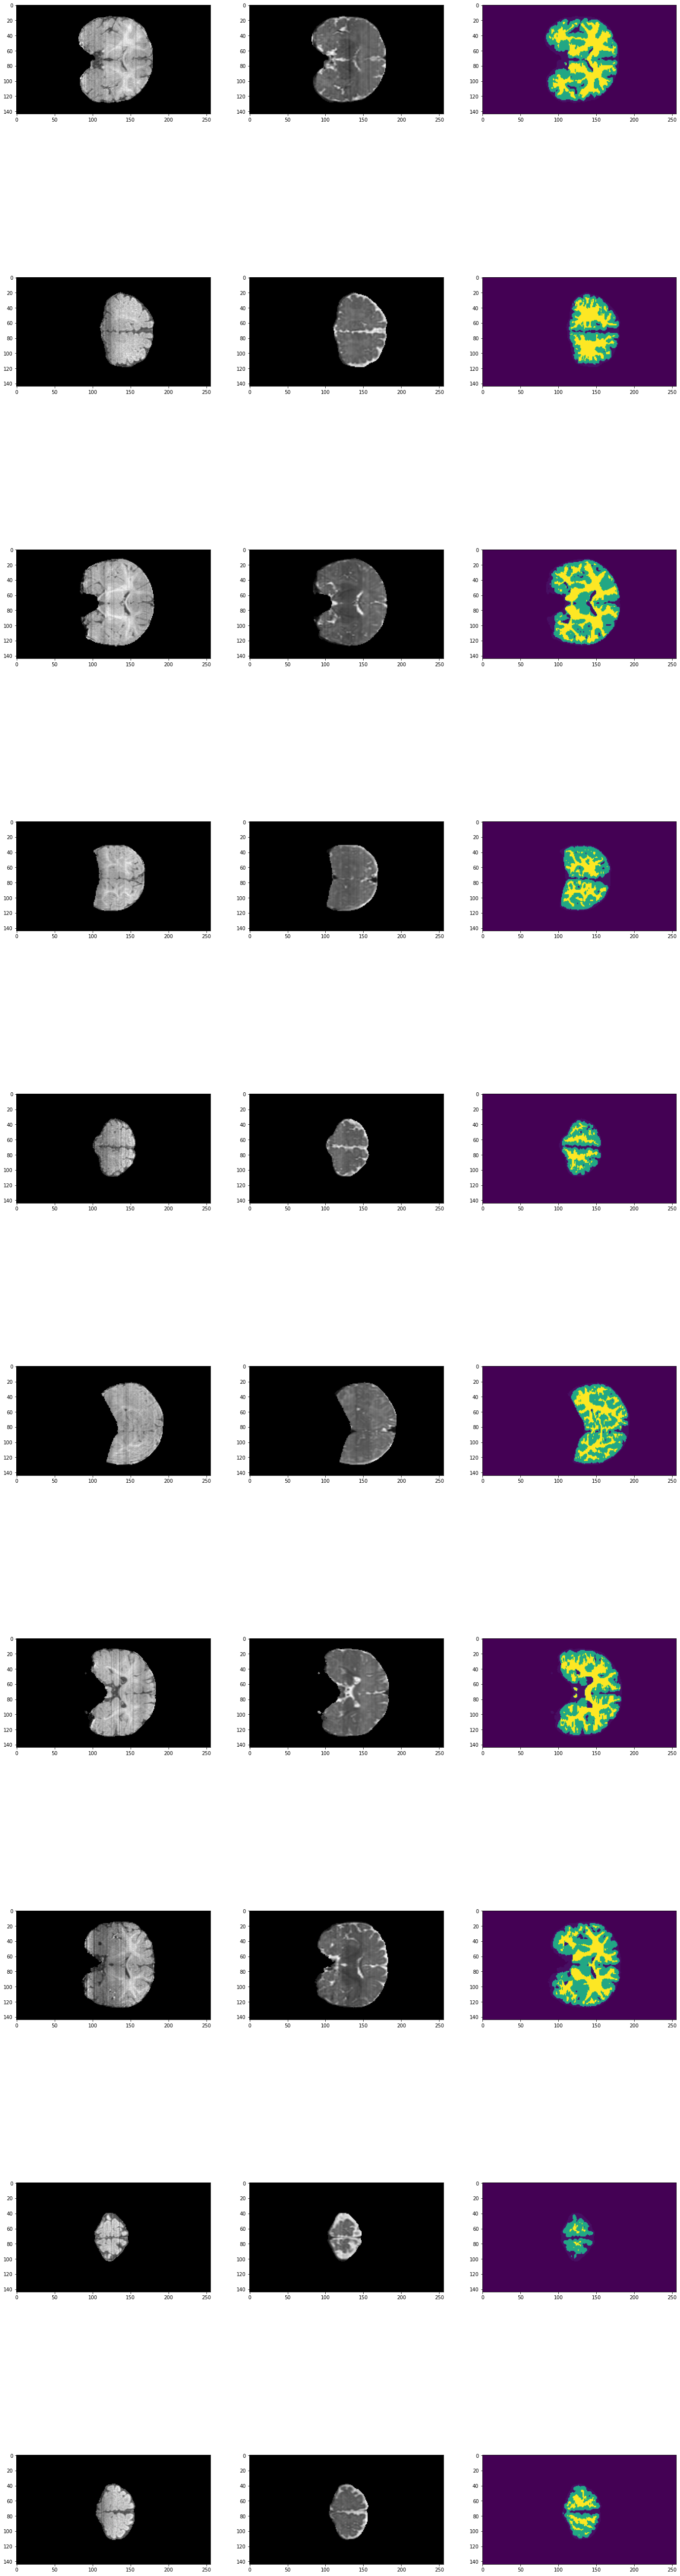

In [42]:
np.save('/content/drive/MyDrive/out.npy', val_preds_2)
out = np.load('/content/drive/MyDrive/out.npy', 'r')
print(out.shape)
print(out.dtype)

fig, ax = plt.subplots(10, 3, figsize=(24, 100))

for plot_index, (image_index, subject_index) in enumerate(zip(image_indices, subject_indices)):
  ax[plot_index, 0].imshow(X_test_2[subject_index, :, image_index, :, 0], cmap='gray')
  ax[plot_index, 1].imshow(X_test_2[subject_index, :, image_index, :, 1], cmap='gray')
  ax[plot_index, 2].imshow(out[subject_index, ..., image_index, :])